# Amharic Analysis

In [995]:
import os, re
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer
from tqdm import tqdm
from collections import Counter
from itertools import islice
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

import flair
from flair.data import Sentence
from flair.models import TextClassifier



In [696]:

#PROJECT_DIR = '/content/drive/MyDrive/afrisent-semeval-2023'
PROJECT_DIR = r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023/'

In [697]:
pd.set_option('display.max_colwidth',None)

In [698]:

# os.path.join(PROJECT_DIR,'SubtaskA/train/formatted-train-data/am/train.tsv')
# #SubtaskA/train/formatted-train-data/am/train.tsv

'E:\\FALL22\\CSCE633_NLP\\nlp_project\\afrisent-semeval-2023/SubtaskA/train/formatted-train-data/am/train.tsv'

In [699]:
## original raw am file
df_am_orig = pd.read_csv(r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023/SubtaskA/train/formatted-train-data/am/train.tsv', sep='\t')

In [700]:
## Check the distribution of the labels
df_am_orig.label.value_counts()

neutral     3104
negative    1548
positive    1332
Name: label, dtype: int64

**Number of neutral examples > sum(number of negative and positive examples)**

In [701]:
df_am_orig

,text,label
0,Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ,negative
1,ይሄው ነው አይደል የእውቀትሽ ጥግ....በሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ አታነቢም....ደሞ ራስሽን አታስገምቺ,negative
2,ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!,negative
3,?? ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወጣ የምንቸክለውን ነገር አስታወሰኝ ???? ምን ሆኖ ነው ግን? ከሗላ ያለው ቴዲ ሁሉ ፊቱን አዞረ እኮ ??,negative
4,ዠልጥ?? ???? ገገማ,negative
...,...,...
5979,ለቀድሞ የአርበኞች ግንቦት 7እንዲሁም አሁን የኢዜማ አባላቶች እንዲሁም ደጋፊዎች መላው ኢትዮጵያውያን እንካን ለገና በአል አደረሳችሁ በአሉ የጤና የሰላም የደስታ የፍቅር ይሁንላችሁ።,positive
5980,አፍሪካዊ መሪዎች እንዲህ በሙሉ ልብ እንዲናገሩ እንፈልጋለን። Black Panther.,positive
5981,መልካም የኢየሱስ ክርስቶስ ልደት በዓል!,positive
5982,2ኛ ወደ ቆሮንቶስ ሰዎች-2 Corinthians :13 14 የጌታ የኢየሱስ ክርስቶስ ጸጋ የእግዚአብሔርም ፍቅር የመንፈስ ቅዱስም ኅብረት ከሁላችሁ ጋር ይሁን።,positive


In [702]:
df_am_orig['text_len_initial'] = df_am_orig.text.apply(lambda x:len(x))
df_am_orig

,text,label,text_len_initial
0,Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ,negative,58
1,ይሄው ነው አይደል የእውቀትሽ ጥግ....በሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ አታነቢም....ደሞ ራስሽን አታስገምቺ,negative,70
2,ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!,negative,35
3,?? ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወጣ የምንቸክለውን ነገር አስታወሰኝ ???? ምን ሆኖ ነው ግን? ከሗላ ያለው ቴዲ ሁሉ ፊቱን አዞረ እኮ ??,negative,113
4,ዠልጥ?? ???? ገገማ,negative,14
...,...,...,...
5979,ለቀድሞ የአርበኞች ግንቦት 7እንዲሁም አሁን የኢዜማ አባላቶች እንዲሁም ደጋፊዎች መላው ኢትዮጵያውያን እንካን ለገና በአል አደረሳችሁ በአሉ የጤና የሰላም የደስታ የፍቅር ይሁንላችሁ።,positive,114
5980,አፍሪካዊ መሪዎች እንዲህ በሙሉ ልብ እንዲናገሩ እንፈልጋለን። Black Panther.,positive,53
5981,መልካም የኢየሱስ ክርስቶስ ልደት በዓል!,positive,25
5982,2ኛ ወደ ቆሮንቶስ ሰዎች-2 Corinthians :13 14 የጌታ የኢየሱስ ክርስቶስ ጸጋ የእግዚአብሔርም ፍቅር የመንፈስ ቅዱስም ኅብረት ከሁላችሁ ጋር ይሁን።,positive,100


In [703]:
df_am_orig.text_len_initial.describe()

count    5984.000000
mean       71.447193
std        36.176696
min         1.000000
25%        39.000000
50%        71.000000
75%       106.000000
max       146.000000
Name: text_len_initial, dtype: float64

Text(0.5, 1.0, 'Text Length across three labels')

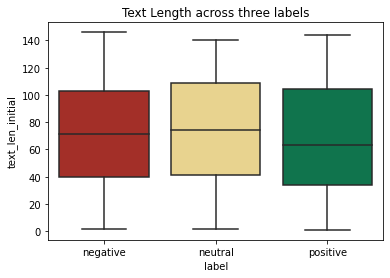

In [1037]:
sns.boxplot(x="label", y="text_len_initial", data=df_am_orig, palette=['#B81D13','#F7DB80','#008450'])
plt.title("Text Length across three labels")

Text length in different classes have similar distribution. The median text length for positive sentiment is somewhat smaller than other classes.

In [705]:
df_am_orig

,text,label,text_len_initial
0,Tesfaye ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ,negative,58
1,ይሄው ነው አይደል የእውቀትሽ ጥግ....በሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ አታነቢም....ደሞ ራስሽን አታስገምቺ,negative,70
2,ዘገበ ይባላል? ሌላ የሚባል ነገር ካለ አንተዉ ንገረን!,negative,35
3,?? ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወጣ የምንቸክለውን ነገር አስታወሰኝ ???? ምን ሆኖ ነው ግን? ከሗላ ያለው ቴዲ ሁሉ ፊቱን አዞረ እኮ ??,negative,113
4,ዠልጥ?? ???? ገገማ,negative,14
...,...,...,...
5979,ለቀድሞ የአርበኞች ግንቦት 7እንዲሁም አሁን የኢዜማ አባላቶች እንዲሁም ደጋፊዎች መላው ኢትዮጵያውያን እንካን ለገና በአል አደረሳችሁ በአሉ የጤና የሰላም የደስታ የፍቅር ይሁንላችሁ።,positive,114
5980,አፍሪካዊ መሪዎች እንዲህ በሙሉ ልብ እንዲናገሩ እንፈልጋለን። Black Panther.,positive,53
5981,መልካም የኢየሱስ ክርስቶስ ልደት በዓል!,positive,25
5982,2ኛ ወደ ቆሮንቶስ ሰዎች-2 Corinthians :13 14 የጌታ የኢየሱስ ክርስቶስ ጸጋ የእግዚአብሔርም ፍቅር የመንፈስ ቅዱስም ኅብረት ከሁላችሁ ጋር ይሁን።,positive,100


### Preprocessing

We shall do some preprocessing on the text data.  
We can remove:  
- Punctuation
- @user mentions
- URLs
- Emojis
- English characters
- Numbers
- Stopwords


In [706]:
def clean_text(row, options):
    """Removes url, mentions, emoji and uppercase from tweets"""
    if options['lowercase']:
        row = row.lower()

    if options['remove_url']:
        row = re.sub(r"(?:\@|https?\://)\S+", "", row)

    if options['remove_mentions']:
        row = re.sub(r"[^\w\s]", "", row)
            
    if options['remove_punctuation']:
        row = re.sub("@[A-Za-z0-9_]+","", row)
    
    if options['remove_numbers']:
        row = re.sub("[0-9_]+","", row)

    if options['remove_eng_chars']:
        row = re.sub("[A-Za-z]+","", row)
        
    if options['demojify']:
      emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
      row = re.sub(emoj, '', row)

    return row



In [707]:
clean_config = {
    'remove_url': True,
    'remove_mentions': True,
    'lowercase': True,
    'remove_numbers': True,
    'remove_eng_chars': True,
    'remove_punctuation':True,
    'demojify': True
    }

In [708]:
df_am_orig['text'] = df_am_orig['text'].apply(clean_text, args=(clean_config,))

In [709]:
df_am_orig['text_len_p1'] = df_am_orig.text.apply(lambda x:len(x))

In [710]:
#character level normalization

#method to normalize character level missmatch such as ጸሀይ and ፀሐይ
def normalize_char_level_mismatch(input_token):
    rep1=re.sub('[ሃኅኃሐሓኻ]','ሀ',input_token)
    rep2=re.sub('[ሑኁዅ]','ሁ',rep1)
    rep3=re.sub('[ኂሒኺ]','ሂ',rep2)
    rep4=re.sub('[ኌሔዄ]','ሄ',rep3)
    rep5=re.sub('[ሕኅ]','ህ',rep4)
    rep6=re.sub('[ኆሖኾ]','ሆ',rep5)
    rep7=re.sub('[ሠ]','ሰ',rep6)
    rep8=re.sub('[ሡ]','ሱ',rep7)
    rep9=re.sub('[ሢ]','ሲ',rep8)
    rep10=re.sub('[ሣ]','ሳ',rep9)
    rep11=re.sub('[ሤ]','ሴ',rep10)
    rep12=re.sub('[ሥ]','ስ',rep11)
    rep13=re.sub('[ሦ]','ሶ',rep12)
    rep14=re.sub('[ዓኣዐ]','አ',rep13)
    rep15=re.sub('[ዑ]','ኡ',rep14)
    rep16=re.sub('[ዒ]','ኢ',rep15)
    rep17=re.sub('[ዔ]','ኤ',rep16)
    rep18=re.sub('[ዕ]','እ',rep17)
    rep19=re.sub('[ዖ]','ኦ',rep18)
    rep20=re.sub('[ጸ]','ፀ',rep19)
    rep21=re.sub('[ጹ]','ፁ',rep20)
    rep22=re.sub('[ጺ]','ፂ',rep21)
    rep23=re.sub('[ጻ]','ፃ',rep22)
    rep24=re.sub('[ጼ]','ፄ',rep23)
    rep25=re.sub('[ጽ]','ፅ',rep24)
    rep26=re.sub('[ጾ]','ፆ',rep25)
    #Normalizing words with Labialized Amharic characters such as በልቱዋል or  በልቱአል to  በልቷል  
    rep27=re.sub('(ሉ[ዋአ])','ሏ',rep26)
    rep28=re.sub('(ሙ[ዋአ])','ሟ',rep27)
    rep29=re.sub('(ቱ[ዋአ])','ቷ',rep28)
    rep30=re.sub('(ሩ[ዋአ])','ሯ',rep29)
    rep31=re.sub('(ሱ[ዋአ])','ሷ',rep30)
    rep32=re.sub('(ሹ[ዋአ])','ሿ',rep31)
    rep33=re.sub('(ቁ[ዋአ])','ቋ',rep32)
    rep34=re.sub('(ቡ[ዋአ])','ቧ',rep33)
    rep35=re.sub('(ቹ[ዋአ])','ቿ',rep34)
    rep36=re.sub('(ሁ[ዋአ])','ኋ',rep35)
    rep37=re.sub('(ኑ[ዋአ])','ኗ',rep36)
    rep38=re.sub('(ኙ[ዋአ])','ኟ',rep37)
    rep39=re.sub('(ኩ[ዋአ])','ኳ',rep38)
    rep40=re.sub('(ዙ[ዋአ])','ዟ',rep39)
    rep41=re.sub('(ጉ[ዋአ])','ጓ',rep40)
    rep42=re.sub('(ደ[ዋአ])','ዷ',rep41)
    rep43=re.sub('(ጡ[ዋአ])','ጧ',rep42)
    rep44=re.sub('(ጩ[ዋአ])','ጯ',rep43)
    rep45=re.sub('(ጹ[ዋአ])','ጿ',rep44)
    rep46=re.sub('(ፉ[ዋአ])','ፏ',rep45)
    rep47=re.sub('[ቊ]','ቁ',rep46) #ቁ can be written as ቊ
    rep48=re.sub('[ኵ]','ኩ',rep47) #ኩ can be also written as ኵ  
    return rep48

In [711]:
df_am_orig['text'] = df_am_orig['text'].apply(lambda x: normalize_char_level_mismatch(x))

In [712]:
df_am_orig['text_len_p2'] = df_am_orig.text.apply(lambda x:len(x))

In [713]:
df_am_orig.head()

,text,label,text_len_initial,text_len_p1,text_len_p2
0,ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ,negative,58,51,51
1,ይሄው ነው አይደል የእውቀትሽ ጥግበሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ አታነቢምደሞ ራስሽን አታስገምቺ,negative,70,62,62
2,ዘገበ ይባላል ሌላ የሚባል ነገር ካለ አንተዉ ንገረን,negative,35,33,33
3,ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወጣ የምንቸክለውን ነገር አስታወሰኝ ምን ሆኖ ነው ግን ከሗላ ያለው ቴዲ ሁሉ ፊቱን አዞረ እኮ,negative,113,104,104
4,ዠልጥ ገገማ,negative,14,8,8


In [714]:
## stopwords amharic
## https://github.com/millzon/wordcloud-am/blob/master/data/stopwords.txt
stop_words_am = open(r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\stopwords_am\stopwords_am.txt', encoding='utf-8').read().split()
#stop_words

In [715]:
def remove_stopwords(text, stopwords):
    """Remove the amharic stopwords from the text data."""
    filtered_text_list = [value for value in text if value not in stopwords]
    filtered_text = ''.join(filtered_text_list)
    return filtered_text

In [716]:
df_am_orig['text'] = df_am_orig.text.apply(lambda x : remove_stopwords(x, stop_words_am))

We can add number of words present in the text.

In [717]:
df_am_orig['num_words_text'] = df_am_orig.text.apply(lambda x:len(x.split(' ')))

In [718]:
df_am_orig

,text,label,text_len_initial,text_len_p1,text_len_p2,num_words_text
0,ለካስ ጭብል ለብሰሽ የፕሮፌሰርን ፎቶ ለጥፈክ እልም ያልክ ባዳ ነክ እፈር ትንሽ,negative,58,51,51,13
1,ይሄው ነው አይደል የእውቀትሽ ጥግበሰሚ ሰሚ ከምትናገሪ ለምን ታሪክ አታነቢምደሞ ራስሽን አታስገምቺ,negative,70,62,62,12
2,ዘገበ ይባላል ሌላ የሚባል ነገር ካለ አንተዉ ንገረን,negative,35,33,33,8
3,ድሮ በዘመነ ኮዳክ ፎቶ ቤት ፍላሹ ፏ ሲል አይናችን ተጨፍኖ እንዳይወጣ የምንቸክለውን ነገር አስታወሰኝ ምን ሆኖ ነው ግን ከሗላ ያለው ቴዲ ሁሉ ፊቱን አዞረ እኮ,negative,113,104,104,28
4,ዠልጥ ገገማ,negative,14,8,8,3
...,...,...,...,...,...,...
5979,ለቀድሞ የአርበኞች ግንቦት እንዲሁም አሁን የኢዜማ አባላቶች እንዲሁም ደጋፊዎች መላው ኢትዮጵያውያን እንካን ለገና በአል አደረሳችሁ በአሉ የጤና የሰላም የደስታ የፍቅር ይሁንላችሁ,positive,114,112,112,21
5980,አፍሪካዊ መሪዎች እንዲህ በሙሉ ልብ እንዲናገሩ እንፈልጋለን,positive,53,39,39,9
5981,መልካም የኢየሱስ ክርስቶስ ልደት በአል,positive,25,24,24,5
5982,ኛ ወደ ቆሮንቶስ ሰዎች የጌታ የኢየሱስ ክርስቶስ ፀጋ የእግዚአብሄርም ፍቅር የመንፈስ ቅዱስም ሀብረት ከሁላችሁ ጋር ይሁን,positive,100,80,80,20


In [719]:
df_am_orig.num_words_text.describe()

count    5984.000000
mean       14.990475
std         7.654154
min         1.000000
25%         8.000000
50%        15.000000
75%        21.000000
max        62.000000
Name: num_words_text, dtype: float64

In [720]:
sum(df_am_orig.text_len_p2 < df_am_orig.text_len_initial), len(df_am_orig)

(5038, 5984)

**We have reduced the length of text in most of the examples.**

In [721]:
#sns.boxplot(x="label", y="text_len_initial", data=df_am_orig)

In [722]:
#sum(df_am_orig.text_len_p2 < 9)

### Find the top-N words from the text.
 - Find top_n words from all the data available.
 - Find top_n words in each class.

In [723]:
top_n = 200

In [724]:
## Combined
df_am_top_n = pd.DataFrame(Counter(" ".join(df_am_orig["text"]).split()).most_common(top_n), columns = ['word','count'])
df_am_top_n.head()

,word,count
0,ነው,2165
1,እና,744
2,ላይ,675
3,ግን,353
4,ሰው,329


In [725]:
## Neutral

df_am_top_n_neu = pd.DataFrame(Counter(" ".join(df_am_orig[df_am_orig.label == 'neutral']["text"]).split()).most_common(top_n),columns = ['word','count']) 
df_am_top_n_neu.head()

,word,count
0,ነው,1131
1,እና,430
2,ላይ,389
3,ግን,206
4,ምን,189


In [726]:
## Negative
df_am_top_n_neu = pd.DataFrame(Counter(" ".join(df_am_orig[df_am_orig.label == 'negative']["text"]).split()).most_common(top_n),columns = ['word','count']) 
df_am_top_n_neu.head()

,word,count
0,ነው,594
1,ላይ,189
2,እና,182
3,ምን,105
4,ብቻ,95


In [727]:
## Positive
df_am_top_n_neu = pd.DataFrame(Counter(" ".join(df_am_orig[df_am_orig.label == 'positive']["text"]).split()).most_common(top_n),columns = ['word','count']) 
df_am_top_n_neu.head()

,word,count
0,ነው,440
1,እና,132
2,ላይ,97
3,መልካም,92
4,አሜን,75


In [728]:
## Function to generate word cloud of amharic text

#mask = np.array(Image.open(r"E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\africa_img.png"))

def amharic_wordcloud(text, max_words, mask_path = r"E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\africa_mask_3.jpg"):
    wordcloud = WordCloud(font_path=r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\fonts\jiretsl.ttf',
                      stopwords = stop_words_am,
                      relative_scaling = 0.8,
                      max_words=max_words,
                      min_font_size=4,
                      mask = np.array(Image.open(mask_path)),
                      #mode="RGBA",
                      background_color="white",
                      contour_color = 'black',
                      contour_width = 1,
                      width=744,
                      height=400,
                      scale=3,
                      font_step=1,
                      collocations=False,
                      margin=2
                      ).generate(wc_text)
    # create coloring from image
    mask = np.array(Image.open(mask_path))
    image_colors = ImageColorGenerator(mask)

    #plt.figure(figsize=(32,16))
    plt.figure(figsize=(14,8),dpi=600)
#     plt.imshow(wordcloud, cmap=plt.cm.gray, interpolation='bilinear')  #
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.title('Word Cloud For Top-'+ str(max_words)+' Words In Given Amharic Text', fontsize=20, c='k')
    plt.axis("off")
    plt.savefig(r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\images/am_topn_wordcloud.png')
    plt.show()

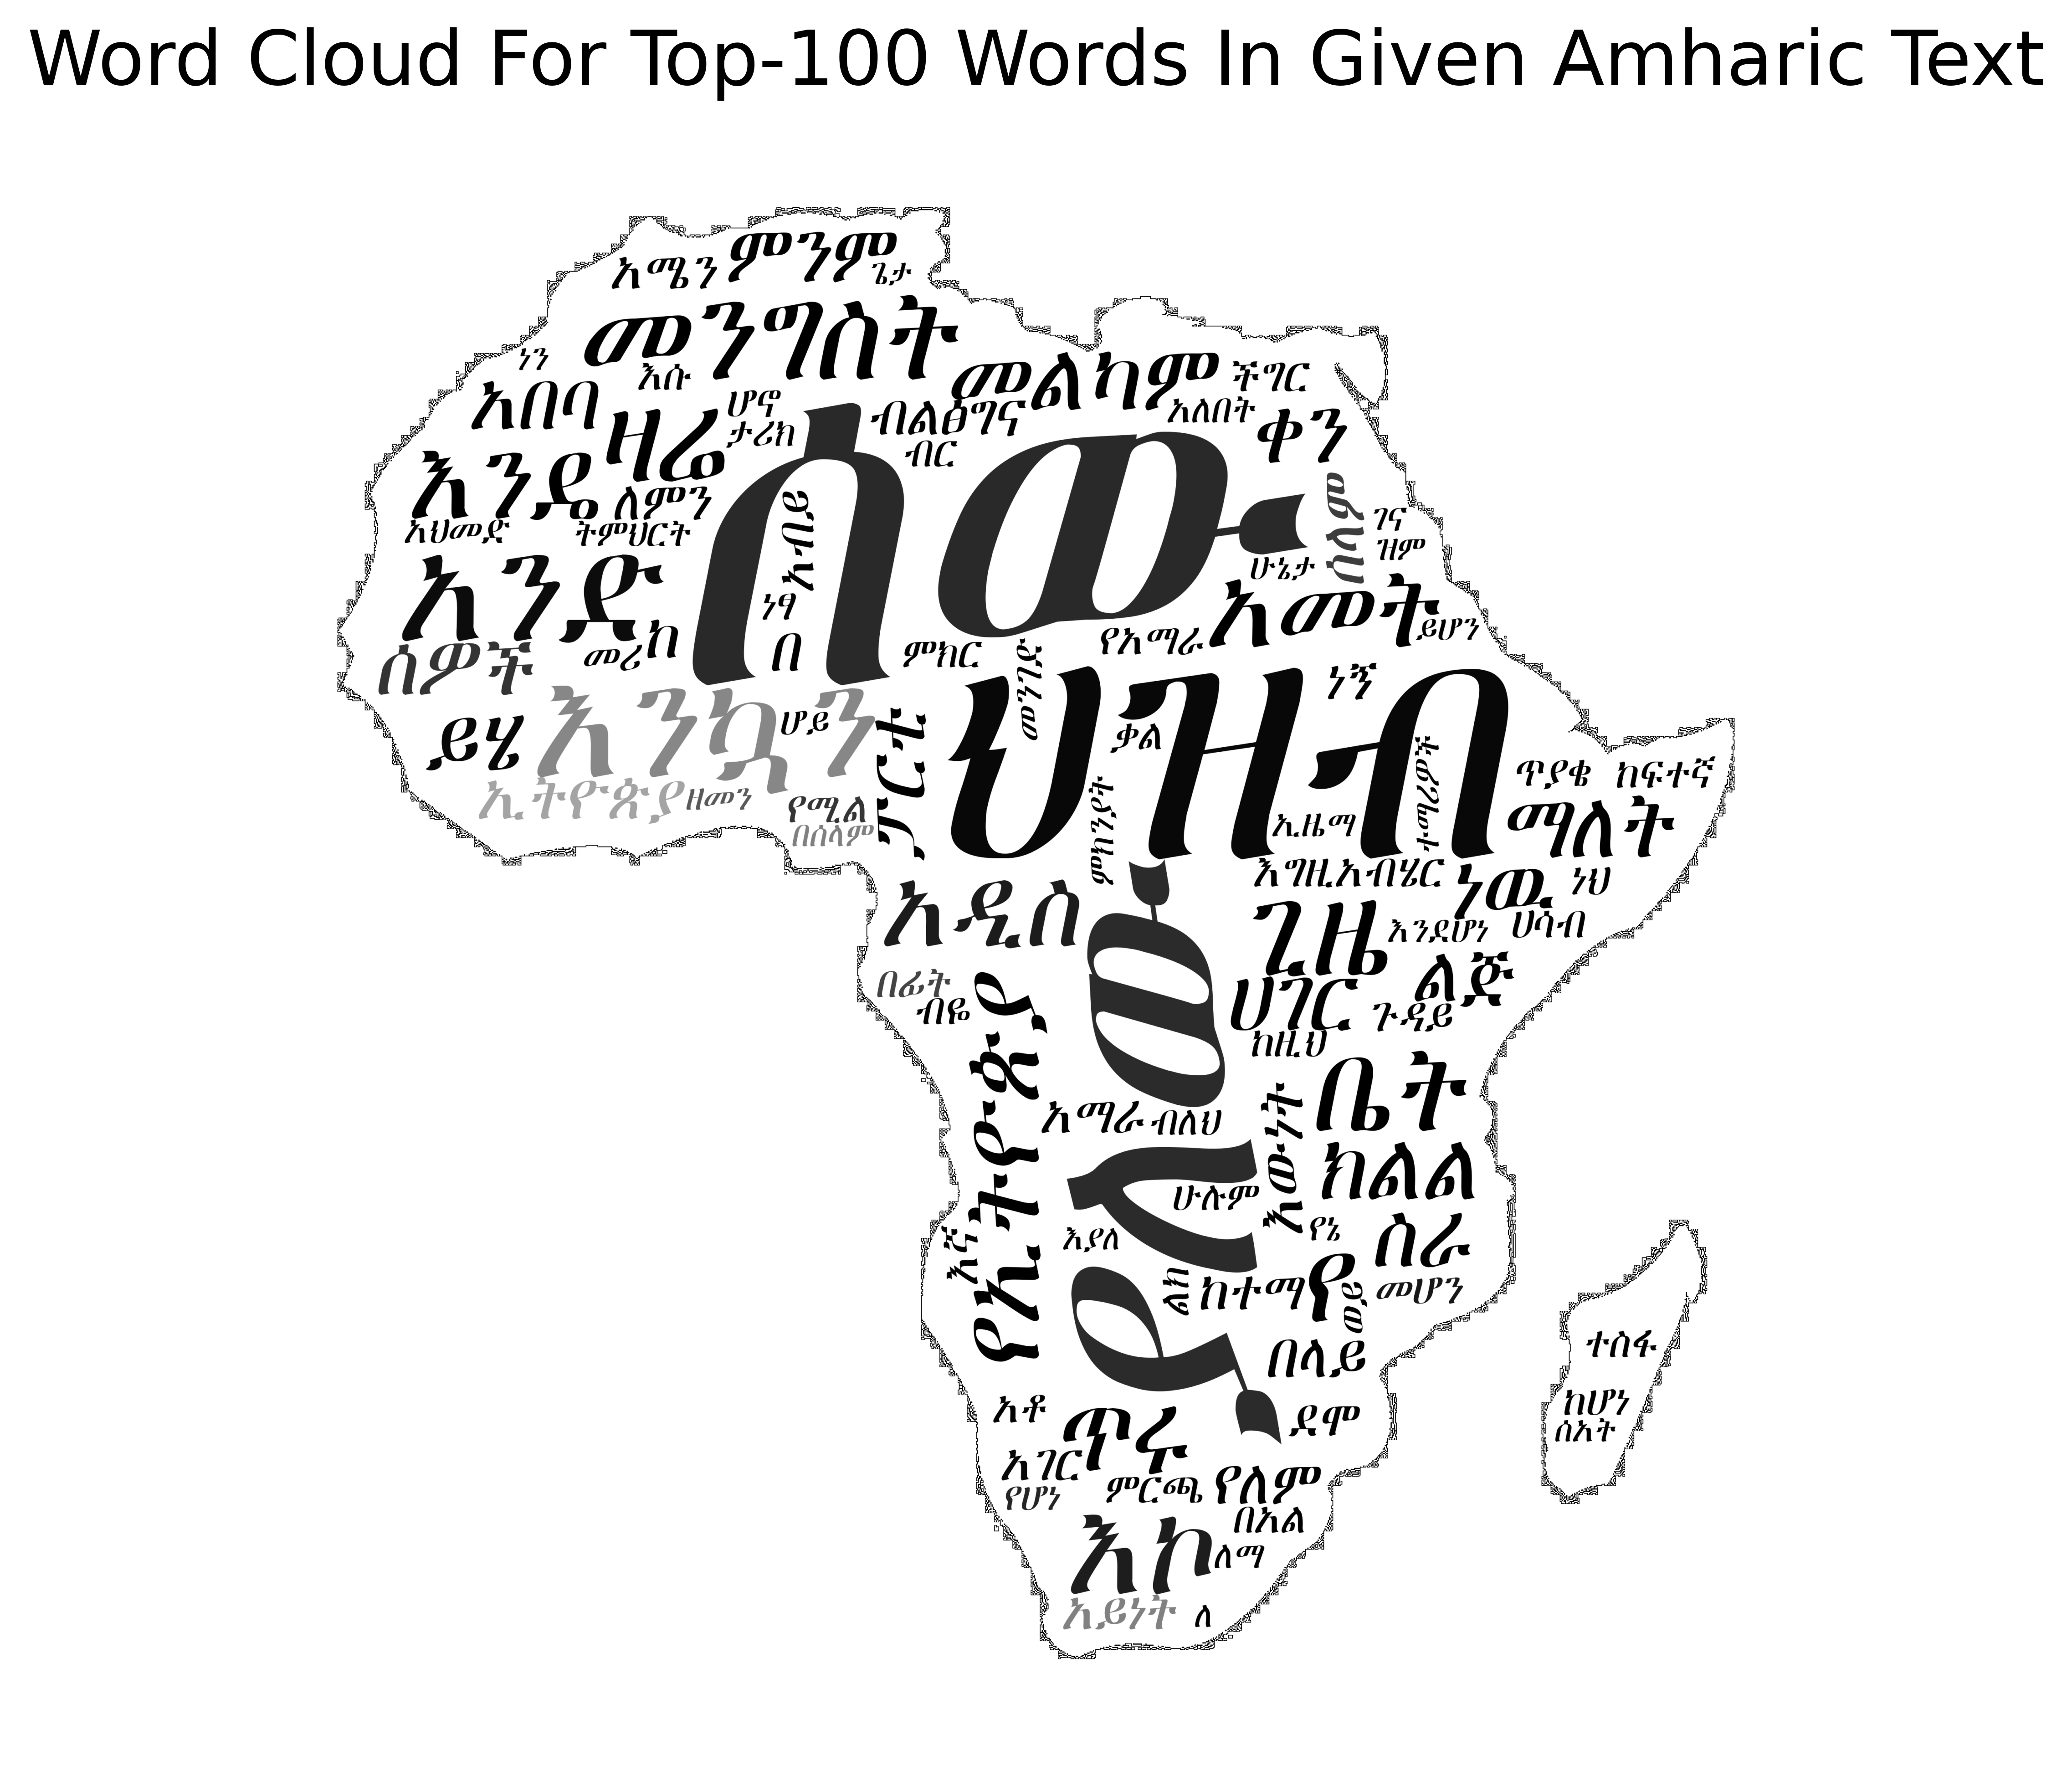

In [729]:
mask_path = r"E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\africa_mask_3.jpg"
wc_text = " ".join(df_am_orig["text"])
amharic_wordcloud(wc_text, 100, mask_path)

In [750]:
#df_am_orig[df_am_orig.text_len_p2 >= 10].label.value_counts()

neutral     3064
negative    1497
positive    1284
Name: label, dtype: int64

### Filter dataset with respect to min_text_len and min_words present in the text.

We can further set constraints on the length of text, number of words present in the text

In [751]:
min_text_len = 7 #10
min_words = 2

In [753]:
def filter_df(df, label, min_text_len, min_words):
    """Filter out the dataframe with respect to min_text_len, min_words."""

    temp_df = df.loc[(df.label == label) & (df.text_len_p2 >= min_text_len) & (df.num_words_text >= min_words),:]#.sort_values('text_len_p2')
    
    return temp_df

In [754]:
df_am_neutral = filter_df(df_am_orig, label='neutral', min_text_len = min_text_len, min_words = min_words)
df_am_negative = filter_df(df_am_orig, label='negative', min_text_len = min_text_len, min_words = min_words)
df_am_positive = filter_df(df_am_orig, label='positive', min_text_len = min_text_len, min_words = min_words)

In [755]:
df_am_neutral.shape, df_am_negative.shape, df_am_positive.shape

((3084, 6), (1515, 6), (1303, 6))

In [756]:
df_am_neutral.columns

Index(['text', 'label', 'text_len_initial', 'text_len_p1', 'text_len_p2',
       'num_words_text'],
      dtype='object')

#### We can concatenate the dataframes and save it as a .tsv file and perform modeling using cross-validation.  
**Another option is to split the data into train-dev-test from the combined file and then do modelling.**

In [757]:
## We can just choose 'text' and 'label' columns while saving.
df_am_filtered = pd.concat([df_am_neutral, df_am_negative, df_am_positive])[['text','label']]
df_am_filtered = df_am_filtered.sample(df_am_filtered.shape[0], replace = False, random_state=1).reset_index()## shuffling the rows
df_am_filtered.drop('index', axis=1,inplace=True)
df_am_filtered.index

RangeIndex(start=0, stop=5902, step=1)

In [758]:
## Save to a file
filtered_path = r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\SubtaskA\train\filtered-train-data\am/'
df_am_filtered.to_csv(filtered_path + 'am_train_filtered.tsv', sep='\t', index=False)

In [759]:
df_am_filtered.label.value_counts()

neutral     3084
negative    1515
positive    1303
Name: label, dtype: int64

### Balanced dataset from the filtered/preprocessed dataset.

### We can make balanced dataset by having same amount of examples for each class.
 - **Under-Sampling:** The examples from the class with minimum size are kept and extra examples from the majority classes are removed. (Can choose at random)  
 - **Over-Sampling:** The examples from the class with maximum size are kept and the examples from the minority classes are increased to that number. (sampling with replace=True). But this results in producing duplicate data. (The model poerformance maynot be good). Another technique called SMOTE didn't work with raw text.

#### Under Sampling

As we have more number of samples, we can do sampling without replacement. But use a specific random_state for reproducibility of the results.

In [760]:
## positive class has minimum size 
sample_size = sum(df_am_filtered.label == 'positive')#

#df_am_filtered_balanced = df_am_filtered.groupby('label').apply(lambda x: x.sample(sample_size, replace=False, random_state=1))

In [761]:
df_am_filtered_pos = df_am_filtered[df_am_filtered['label'] == 'positive'].sample(sample_size, replace=False, random_state=1)
df_am_filtered_neg = df_am_filtered[df_am_filtered['label'] == 'negative'].sample(sample_size, replace=False, random_state=1)
df_am_filtered_neu = df_am_filtered[df_am_filtered['label'] == 'neutral'].sample(sample_size, replace=False, random_state=1)

In [762]:
df_am_filtered_pos.shape,df_am_filtered_neg.shape,df_am_filtered_neu.shape

((1303, 2), (1303, 2), (1303, 2))

In [763]:
## Create a balanced dataset
df_am_filtered_balanced = pd.concat([df_am_filtered_pos, df_am_filtered_neg, df_am_filtered_neu])
df_am_filtered_balanced = df_am_filtered_balanced.sample(df_am_filtered_balanced.shape[0], replace = False, random_state=1).reset_index()## shuffling the rows
df_am_filtered_balanced.drop('index', axis=1,inplace=True)
#df_am_filtered_balanced.index
df_am_filtered_balanced.head()

,text,label
0,ነጋን እንደምትፈሩ እግዚአብሄርን ብትፈሩ የት በደረሳችሁ ያው ግልፅ ጦርነቱ በይፋ ተከፍቷል እስኬው የአንድ ሺህ ሰው ግምት እንዲህ አንቀጥቅጥልኝ,neutral
1,ይድረስ ለተከበሩ ወሮ ዳግማዊት ሞገስ ተጣፈ ተመንዝ ሰዎች ጉዳዪ መንገዳችን ወይ በጋችንን,positive
2,በጣም ጥሩ ግምት ኮፍያው ከወለቀ በኋላ አእምሮክ ነፃ ሆኖ እያሰበ ነው መነፅሩን ስታወልቅ ደሞ የወደፊቱ የሚታይህ ይመስላል,neutral
3,የብሪታኒያ መንግስት ሀገሪቱ ከአውሮፓ ህብረት በቅርቡ እንድትወጣ እሰራለሁ አለ,neutral
4,አሜን ሰላም ብሩህ ሳምንት,positive


In [764]:
## Save as a .tsv file
filtered_balanced_path = r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\SubtaskA\train\filtered-balanced-train-data\am/'
df_am_filtered_balanced.to_csv(filtered_balanced_path + 'am_train_filtered_balanced.tsv', sep='\t', index=False)

In [765]:
df_am_filtered_balanced.columns

Index(['text', 'label'], dtype='object')

### Baseline models

We can check the following model strategies as baselines:  
 - **Stratified:** Generates predictions by respecting the training set’s class distribution.  
 - **Uniform:** Generates predictions uniformly at random.  
 - **Most frequent:** Always predicts the most frequent label in the training set.  


In [993]:
clf_stratified = DummyClassifier(strategy="stratified", random_state=1)
clf_uniform = DummyClassifier(strategy="uniform", random_state=1)
clf_most_frequent = DummyClassifier(strategy="most_frequent", random_state=1)

In [994]:
df_am_filtered.shape, df_am_filtered_balanced.shape

((5902, 2), (3909, 2))

In [996]:
def get_scores(y_true, y_pred):
    """Get true values and predicted values and give the predicted scores"""
    f1_score_macro = f1_score(y_true, y_pred, average='macro')   
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    results = {'f1_score_macro' : f1_score_macro,
              'accuracy' : accuracy,
              'recall_score' : recall,
              'precision_score' : precision}
    return results

### Baseline models on Filtered dataset

#### Stratified model

In [997]:
clf_stratified.fit(df_am_filtered.text, df_am_filtered.label)
y_pred_strat = clf_stratified.predict(df_am_filtered.text)

In [998]:
results_strat = get_scores(df_am_filtered.label, y_pred_strat)

In [999]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_strat)

{   'accuracy': 0.39562860047441545,
    'f1_score_macro': 0.34103043136736994,
    'precision_score': array([0.26792963, 0.52888028, 0.22641509]),
    'recall_score': array([0.26138614, 0.53145266, 0.23023791])}


In [1000]:
print(classification_report(df_am_filtered.label, y_pred_strat))

              precision    recall  f1-score   support

    negative       0.27      0.26      0.26      1515
     neutral       0.53      0.53      0.53      3084
    positive       0.23      0.23      0.23      1303

    accuracy                           0.40      5902
   macro avg       0.34      0.34      0.34      5902
weighted avg       0.40      0.40      0.40      5902



#### Uniform model

In [1001]:
clf_uniform.fit(df_am_filtered.text, df_am_filtered.label)
y_pred_unif = clf_uniform.predict(df_am_filtered.text)

In [1002]:
results_unif = get_scores(df_am_filtered.label, y_pred_unif)

In [1003]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_unif)

{   'accuracy': 0.32836326668925786,
    'f1_score_macro': 0.3147684371160626,
    'precision_score': array([0.23993727, 0.53179487, 0.21677293]),
    'recall_score': array([0.3029703 , 0.33625162, 0.33921719])}


In [1004]:
print(classification_report(df_am_filtered.label, y_pred_unif))

              precision    recall  f1-score   support

    negative       0.24      0.30      0.27      1515
     neutral       0.53      0.34      0.41      3084
    positive       0.22      0.34      0.26      1303

    accuracy                           0.33      5902
   macro avg       0.33      0.33      0.31      5902
weighted avg       0.39      0.33      0.34      5902



#### Most frequent model

In [1011]:
clf_most_frequent.fit(df_am_filtered.text, df_am_filtered.label)
y_pred_most_freq = clf_most_frequent.predict(df_am_filtered.text)

In [1012]:
results_most_freq = get_scores(df_am_filtered.label, y_pred_most_freq)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1013]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_most_freq)

{   'accuracy': 0.5225347339884785,
    'f1_score_macro': 0.22880035610950367,
    'precision_score': array([0.        , 0.52253473, 0.        ]),
    'recall_score': array([0., 1., 0.])}


In [1014]:
print(classification_report(df_am_filtered.label, y_pred_most_freq))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1515
     neutral       0.52      1.00      0.69      3084
    positive       0.00      0.00      0.00      1303

    accuracy                           0.52      5902
   macro avg       0.17      0.33      0.23      5902
weighted avg       0.27      0.52      0.36      5902



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Baseline models on Filtered-Balanced dataset

#### Stratified model

In [1015]:
clf_stratified.fit(df_am_filtered_balanced.text, df_am_filtered_balanced.label)
y_pred_strat = clf_stratified.predict(df_am_filtered_balanced.text)

In [1016]:
results_strat = get_scores(df_am_filtered_balanced.label, y_pred_strat)

In [1017]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_strat)

{   'accuracy': 0.3479150677922742,
    'f1_score_macro': 0.34777822703796657,
    'precision_score': array([0.35519126, 0.34567901, 0.34292566]),
    'recall_score': array([0.34919417, 0.36531082, 0.32924021])}


In [1018]:
print(classification_report(df_am_filtered_balanced.label, y_pred_strat))

              precision    recall  f1-score   support

    negative       0.36      0.35      0.35      1303
     neutral       0.35      0.37      0.36      1303
    positive       0.34      0.33      0.34      1303

    accuracy                           0.35      3909
   macro avg       0.35      0.35      0.35      3909
weighted avg       0.35      0.35      0.35      3909



#### Uniform model

In [1019]:
clf_uniform.fit(df_am_filtered_balanced.text, df_am_filtered_balanced.label)
y_pred_unif = clf_uniform.predict(df_am_filtered_balanced.text)

In [1020]:
results_unif = get_scores(df_am_filtered_balanced.label, y_pred_unif)

In [1021]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_unif)

{   'accuracy': 0.33563571245842927,
    'f1_score_macro': 0.33555796565000523,
    'precision_score': array([0.32789433, 0.33829287, 0.34052045]),
    'recall_score': array([0.323868  , 0.33154259, 0.35149655])}


In [1022]:
print(classification_report(df_am_filtered_balanced.label, y_pred_unif))

              precision    recall  f1-score   support

    negative       0.33      0.32      0.33      1303
     neutral       0.34      0.33      0.33      1303
    positive       0.34      0.35      0.35      1303

    accuracy                           0.34      3909
   macro avg       0.34      0.34      0.34      3909
weighted avg       0.34      0.34      0.34      3909



#### Most frequent model

In [1023]:
clf_most_frequent.fit(df_am_filtered_balanced.text, df_am_filtered_balanced.label)
y_pred_most_freq = clf_most_frequent.predict(df_am_filtered_balanced.text)

In [1024]:
results_most_freq = get_scores(df_am_filtered_balanced.label, y_pred_most_freq)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1025]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results_most_freq)

{   'accuracy': 0.3333333333333333,
    'f1_score_macro': 0.16666666666666666,
    'precision_score': array([0.33333333, 0.        , 0.        ]),
    'recall_score': array([1., 0., 0.])}


In [1026]:
print(classification_report(df_am_filtered_balanced.label, y_pred_most_freq))

              precision    recall  f1-score   support

    negative       0.33      1.00      0.50      1303
     neutral       0.00      0.00      0.00      1303
    positive       0.00      0.00      0.00      1303

    accuracy                           0.33      3909
   macro avg       0.11      0.33      0.17      3909
weighted avg       0.11      0.33      0.17      3909



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Train-dev-test split (70/15/15)

#### For filtered data

In [864]:
df_am_filtered.shape

(5902, 2)

In [865]:
df_am_filtered.label.value_counts()

neutral     3084
negative    1515
positive    1303
Name: label, dtype: int64

In [871]:
## from the starter code
train_f, dev_f, test_f = np.split(df_am_filtered.sample(frac=1, random_state=1), [int(.7*len(df_am_filtered)), int(.85*len(df_am_filtered))])

In [872]:
train_f.shape, dev_f.shape, test_f.shape

((4131, 2), (885, 2), (886, 2))

In [873]:
print(train_f.label.value_counts(), dev_f.label.value_counts(), test_f.label.value_counts(), sep='\n\n')

neutral     2156
negative    1051
positive     924
Name: label, dtype: int64

neutral     470
negative    225
positive    190
Name: label, dtype: int64

neutral     458
negative    239
positive    189
Name: label, dtype: int64


In [879]:
fil_split_path = r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\SubtaskA\train\fil-splitted-train-dev-test\am/'

In [880]:

train_f.sample(frac=1).to_csv(fil_split_path + 'train.tsv', sep='\t', index=False)
dev_f.sample(frac=1).to_csv(fil_split_path + 'dev.tsv', sep='\t', index=False)
test_f.sample(frac=1).to_csv(fil_split_path + 'test.tsv', sep='\t', index=False)

#### For filtered and balanced data

In [874]:
df_am_filtered_balanced.shape

(3909, 2)

In [875]:
df_am_filtered_balanced.label.value_counts()

neutral     1303
positive    1303
negative    1303
Name: label, dtype: int64

In [876]:
train_fb, dev_fb, test_fb = np.split(df_am_filtered_balanced.sample(frac=1, random_state=1), [int(.7*len(df_am_filtered_balanced)), int(.85*len(df_am_filtered_balanced))])

In [877]:
train_fb.shape, dev_fb.shape, test_fb.shape

((2736, 2), (586, 2), (587, 2))

In [878]:
print(train_fb.label.value_counts(), dev_fb.label.value_counts(), test_fb.label.value_counts(), sep='\n\n')

positive    917
negative    913
neutral     906
Name: label, dtype: int64

neutral     201
positive    193
negative    192
Name: label, dtype: int64

negative    198
neutral     196
positive    193
Name: label, dtype: int64


As we can see that each of train-dev-test split has around the same proportion of class labels with respect to data before the split. We can follow this procedure to split the data.

In [881]:
fil_bal_split_path = r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\SubtaskA\train\fil-bal-splitted-train-dev-test\am/'

In [882]:

train_fb.sample(frac=1).to_csv(fil_bal_split_path + 'train.tsv', sep='\t', index=False)
dev_fb.sample(frac=1).to_csv(fil_bal_split_path + 'dev.tsv', sep='\t', index=False)
test_fb.sample(frac=1).to_csv(fil_bal_split_path + 'test.tsv', sep='\t', index=False)

#### The train-dev-split datasets to be uploaded to google drive from which we can use the given starter code with redirecting to the path where these files are present for fitting hugging face models or other deep learning models.

### Perform analysis on using LinearSVC, Naive Bayes

In [854]:
## Number of unique words in the given data.
# len(set(" ".join(df_am_filtered["text"]).split()))
len(set(" ".join(df_am_filtered_balanced["text"]).split()))

21833

In [855]:
# VOCAB_SIZE = 25000 ## filtered
VOCAB_SIZE = 20000 ## filtered+balanced


In [856]:
def get_data_and_labels(tsv_path):
    df = pd.read_csv(tsv_path, sep='\t')
    #data = df['tweet'].to_list()
    data = df['text'].to_list()
    labels = df['label'].to_list()
    labels = [t.strip().upper() for t in labels]
    return data, np.array(labels)

In [848]:
def identity_tokenizer(text):
    return text

def get_features(corpus, vocab_size):
    vectorizer = CountVectorizer(  ## for multinomial NB
#     vectorizer = TfidfVectorizer(  ## for linear SVC
        ngram_range=(1, 2),
        max_features=vocab_size,
        tokenizer=identity_tokenizer, # already receiving tokenized text from AUtotokenizer
        lowercase=False,
        token_pattern=None
    )
    vectorizer.fit(corpus)
    X = vectorizer.transform(corpus)
    return X, vectorizer

In [813]:
# help(LinearSVC)
# help(StratifiedKFold)

In [849]:
def evaluate_kflod(data, true_labels, tokenizer):
    skf = StratifiedKFold(n_splits=5)   #10
    tokenized_texts_str = [tokenizer.convert_ids_to_tokens(text) for text in tokenizer(data)['input_ids']]
    features,_ = get_features(tokenized_texts_str, VOCAB_SIZE)
    true_test_labels = []
    predicted_test_labels = []
    for train_index, test_index in skf.split(features, true_labels):
#         classifier = LinearSVC(C=5,max_iter=1000)  #0.2, C=100,max_iter=10000
        classifier = MultinomialNB()
        train_labels = true_labels[train_index]
        classifier.fit(features[train_index], train_labels)
        train_predictions = classifier.predict(features[train_index])
        test_predictions = classifier.predict(features[test_index])
        test_labels = true_labels[test_index]
        true_test_labels.extend(test_labels)
        predicted_test_labels.extend(test_predictions)
        # train_f1 = f1_score(train_labels, train_predictions, average='micro', labels=['NEGATIVE', 'NEUTRAL','POSITIVE'])
        # test_f1 = f1_score(test_labels, test_predictions, average='micro', labels=['NEGATIVE', 'NEUTRAL','POSITIVE'])
        # print(f"Train F1: {train_f1}, Test F1: {test_f1}")
    return true_test_labels, predicted_test_labels

In [850]:
def evaluate_model_and_dataset(data_set_path):
    data_files = sorted(Path(data_set_path).glob('*.tsv'))
    african_language_model = 'Davlan/afro-xlmr-mini'
    tokenizer = AutoTokenizer.from_pretrained(african_language_model)
    results = []
    
    true_labels_details  = []
    predicted_labels_details  = []
    
    for csv_file in tqdm(data_files, total=len(data_files)):
        language = csv_file.stem.split('_')[0]
        model = "Multinomial Naive Bayes"
#         model = "Linear SVC"

        data, true_labels = get_data_and_labels(csv_file)
        label_set = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']
        true_labels, predicted_labels = evaluate_kflod(data, true_labels, tokenizer)
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, labels=label_set, average=None)
        recall = recall_score(true_labels, predicted_labels, labels=label_set, average=None)
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        
        true_labels_details.append(true_labels)
        predicted_labels_details.append(predicted_labels)
        
        output = {  'model': model,
                    'language': language,
                    'num_examples': len(data),
                    'precision': {label_set[i]: precision[i] for i in range(len(label_set))},
                    'recall': {label_set[i]: recall[i] for i in range(len(label_set))},
                    'f1_score_macro': f1,
                    'accuracy': accuracy
                }
        results.append(output)
    return results, true_labels_details, predicted_labels_details

In [857]:
# filtered_path
filtered_balanced_path

'E:\\FALL22\\CSCE633_NLP\\nlp_project\\afrisent-semeval-2023\\SubtaskA\\train\\filtered-balanced-train-data\\am/'

In [858]:
#train_data_path = r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\SubtaskA\train\am/'

# train_data_path = filtered_path

train_data_path = filtered_balanced_path

results, tr_labels, pr_labels = evaluate_model_and_dataset(train_data_path)
# df = pd.DataFrame(results)
# df.to_excel('../reports/linear_svm_evaluation.xlsx')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


### Linear SVC results with filtered dataset

In [798]:
## linearSVC, cv = 5, C=0.2
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,5902,"{'NEGATIVE': 0.5280665280665281, 'POSITIVE': 0.719626168224299, 'NEUTRAL': 0.5714285714285714}","{'NEGATIVE': 0.16765676567656765, 'POSITIVE': 0.29547198772064465, 'NEUTRAL': 0.9053177691309987}",0.458023,0.581328


In [777]:
## linearSVC, cv = 5, C=1.5
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,5902,"{'NEGATIVE': 0.41907261592300965, 'POSITIVE': 0.5562435500515995, 'NEUTRAL': 0.5846965699208443}","{'NEGATIVE': 0.31617161716171616, 'POSITIVE': 0.4136607828089025, 'NEUTRAL': 0.7185473411154345}",0.493214,0.54795


In [793]:
## linearSVC, cv = 5, C=5
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,5902,"{'NEGATIVE': 0.4115384615384615, 'POSITIVE': 0.5331412103746398, 'NEUTRAL': 0.5885987082280258}","{'NEGATIVE': 0.35313531353135313, 'POSITIVE': 0.4259401381427475, 'NEUTRAL': 0.6796368352788587}",0.494835,0.539817


In [803]:
## linearSVC, cv = 5, C=7
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,5902,"{'NEGATIVE': 0.4084720121028744, 'POSITIVE': 0.529467680608365, 'NEUTRAL': 0.5881519274376418}","{'NEGATIVE': 0.3564356435643564, 'POSITIVE': 0.4274750575594781, 'NEUTRAL': 0.6728274967574579}",0.493789,0.537445


In [782]:
## linearSVC, cv = 5, C=10
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,5902,"{'NEGATIVE': 0.4030075187969925, 'POSITIVE': 0.5191053122087604, 'NEUTRAL': 0.58673906830523}","{'NEGATIVE': 0.3537953795379538, 'POSITIVE': 0.4274750575594781, 'NEUTRAL': 0.6656939040207522}",0.489795,0.53304


In [808]:
## linearSVC, cv = 5, C=100
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,5902,"{'NEGATIVE': 0.39577259475218657, 'POSITIVE': 0.5035971223021583, 'NEUTRAL': 0.5868929198361615}","{'NEGATIVE': 0.3584158415841584, 'POSITIVE': 0.4297774366845741, 'NEUTRAL': 0.6504539559014267}",0.485659,0.526771


### Linear SVC results with filtered balanced dataset

In [818]:
## linearSVC, cv = 5, C=0.2
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,3909,"{'NEGATIVE': 0.505072463768116, 'POSITIVE': 0.5976653696498054, 'NEUTRAL': 0.4284565916398714}","{'NEGATIVE': 0.5349194167306216, 'POSITIVE': 0.5894090560245587, 'NEUTRAL': 0.40905602455871065}",0.510536,0.511128


In [823]:
## linearSVC, cv = 5, C=1.5
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,3909,"{'NEGATIVE': 0.4828358208955224, 'POSITIVE': 0.5920436817472698, 'NEUTRAL': 0.41181041181041184}","{'NEGATIVE': 0.4965464313123561, 'POSITIVE': 0.5825019186492709, 'NEUTRAL': 0.40675364543361475}",0.495365,0.495267


In [828]:
## linearSVC, cv = 5, C=5
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,3909,"{'NEGATIVE': 0.4767616191904048, 'POSITIVE': 0.5766192733017378, 'NEUTRAL': 0.3964858670741024}","{'NEGATIVE': 0.48810437452033767, 'POSITIVE': 0.5602455871066769, 'NEUTRAL': 0.3983115886415963}",0.482692,0.482221


In [833]:
## linearSVC, cv = 5, C=7
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,3909,"{'NEGATIVE': 0.4760119940029985, 'POSITIVE': 0.5734597156398105, 'NEUTRAL': 0.3949579831932773}","{'NEGATIVE': 0.4873369148119724, 'POSITIVE': 0.5571757482732157, 'NEUTRAL': 0.3967766692248657}",0.480891,0.48043


In [838]:
## linearSVC, cv = 5, C=10
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,3909,"{'NEGATIVE': 0.4756554307116105, 'POSITIVE': 0.5694006309148265, 'NEUTRAL': 0.39663093415007655}","{'NEGATIVE': 0.4873369148119724, 'POSITIVE': 0.5541059094397545, 'NEUTRAL': 0.397544128933231}",0.480054,0.479662


In [843]:
## linearSVC, cv = 5, C=100
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Linear SVC,am,3909,"{'NEGATIVE': 0.4772382397572079, 'POSITIVE': 0.5517241379310345, 'NEUTRAL': 0.38935361216730036}","{'NEGATIVE': 0.4827321565617805, 'POSITIVE': 0.5402916346891788, 'NEUTRAL': 0.39293937068303914}",0.472352,0.471988


### Multinomial Naive Bayes results with filtered dataset

In [853]:
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Multinomial Naive Bayes,am,5902,"{'NEGATIVE': 0.424881033310673, 'POSITIVE': 0.5783132530120482, 'NEUTRAL': 0.6005822416302765}","{'NEGATIVE': 0.41254125412541254, 'POSITIVE': 0.442056792018419, 'NEUTRAL': 0.6689364461738002}",0.517542,0.553033


### Multinomial Naive Bayes results with filtered balanced dataset

In [859]:
df_results = pd.DataFrame(results)
df_results

,model,language,num_examples,precision,recall,f1_score_macro,accuracy
0,Multinomial Naive Bayes,am,3909,"{'NEGATIVE': 0.489501312335958, 'POSITIVE': 0.6187290969899666, 'NEUTRAL': 0.4146341463414634}","{'NEGATIVE': 0.5725249424405219, 'POSITIVE': 0.56792018419033, 'NEUTRAL': 0.37835763622409824}",0.505224,0.506268


### Flair pre-trained model specifically for Amharic text.

In [893]:
# import wget
import flair
from flair.data import Sentence


In [894]:
# predict class and print
from flair.models import TextClassifier

In [895]:
am_sent_model = r'E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\pretrained_models\final-model.pt'

In [897]:
classifier = TextClassifier.load(am_sent_model)

2022-11-27 00:07:35,212 loading file E:\FALL22\CSCE633_NLP\nlp_project\afrisent-semeval-2023\pretrained_models\final-model.pt


In [899]:
classifier.predict(Sentence('ስንት ምስኪን ነበር ያኔ:: አንዱ ሲኒየር ነን ካፌ ላድርጋችሁ ብሎን ስንት ምግብ አዘን አብሮ የበላውን ክፈሉ ብሎን ጠፍቷል'))

In [982]:
def get_label_flair(text, classifier = classifier):
    """Get text/sentence from the dataframe and use the flair model to predict the label"""
    sentence = Sentence(text)
    classifier.predict(sentence)  ## 'all labels' -- can be []
    all_labels_list = sentence.to_dict()['all labels']
    if len(all_labels_list) == 0 :
        ## can choose one of ['neutral', 'negative', 'positive'] at random
        ## or choose 'neutral' because it was the most common thing, if we aren't sure of sentiment
        label_pred = 'neutral'  ## np.random.choice(['neutral', 'negative', 'positive'], 1)[0]
        return label_pred
    else:
        label_pred = all_labels_list[0]['value'].lower()
        return label_pred

In [991]:
def get_labels(file_path):
    """Get the .tsv file with text and label and give the true and the predicted labels."""
    df = pd.read_csv(file_path, sep='\t')
    y_true = df.label.to_list() ## comment this cell, if the file has only text column
    y_pred = df.iloc[:]['text'].apply(lambda x : get_label_flair(x)).to_list()
    return y_true, y_pred ## remove the y_true variable if the file has only text column

In [990]:
def get_scores(y_true, y_pred):
    """Get true values and predicted values and give the predicted scores"""
    f1_score_macro = f1_score(y_true, y_pred, average='macro')   
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    results = {'f1_score_macro' : f1_score_macro,
              'accuracy' : accuracy,
              'recall_score' : recall,
              'precision_score' : precision}
    return results

#### Below are the steps used for evaluation of the flair contextual model. Implemented in colab for better runtime.

In [ ]:
## Give the location of the .tsv file whose predicted sentiments are to be compared with the true sentiments.
#file_path = os.path.join(PROJECT_DIR, TASK, 'train', 'filtered-balanced-train-data', LANGUAGE_CODE, 'am_train_filtered_balanced.tsv')


In [ ]:
# true_vals, pred_vals = get_labels(file_path = file_path)

In [ ]:
# model_results = get_scores(true_vals, pred_vals)
# print(model_results)

In [ ]:
# print(classification_report(true_vals, pred_vals))